In [1]:
!nvidia-smi

Wed Feb 19 00:39:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX150       On   | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0    N/A /  N/A |    448MiB /  2002MiB |      8%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import torch
import torchvision
from torchvision import transforms
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
# 3*3 convolutino
def conv3x3(in_channels, out_channels, stride=1):
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = torch.nn.BatchNorm2d(16)
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 1)
        self.layer4 = self.make_layer(block, 128, layers[1], 2)
        self.max_pool = torch.nn.MaxPool2d(8)
        self.fc = torch.nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = torch.nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                torch.nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
print(device)

cuda:0


In [7]:
net = torch.load('/home/matvey/Morozov/Научрук/Диплом/Diploma-Thesis/Модель/Models/CIFAR10_ResNet.pth')
net.eval()

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [8]:
test_tf = transforms.Compose([
    transforms.ToTensor()
])

test = torchvision.datasets.CIFAR10('Модель/Datasets', download=False, train=False, transform=test_tf)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=256, shuffle=False)

#### Классы

In [9]:
labels = {
0 : 'airplane',
1 : 'automobile',
2 : 'bird',
3 : 'cat',
4 : 'deer',
5 : 'dog',
6 : 'frog',
7 : 'horse',
8 : 'ship',
9 : 'truck'
}

### SimBA

In [10]:
import utils
import sys

/home/matvey/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [11]:
def normalize(x):
    return utils.apply_normalization(x, 'cifar')

def get_probs(model, x, y):
    output = model(normalize(x.cuda())).cpu()
    probs = torch.nn.Softmax()(output)[:, y]
    return torch.diag(probs.data)

def simba_single(model, x, y, num_iters=10000, epsilon=0.2):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs(model, x, y)
    
    init_label = np.argmax(model(x.cuda()).data.cpu().numpy())
    
    iteration = 0
    
    difference = torch.zeros(n_dims).view(x.size())
    
    while True:
        diff = torch.zeros(n_dims)
        diff[torch.randint(0, 32*32, (1,))[0]] = epsilon     
        left_prob = get_probs(model, (x - diff.view(x.size()).to(device)).clamp(0, 1), y)
        
        if left_prob < last_prob:
            x = (x - diff.view(x.size()).to(device)).clamp(0, 1)
            last_prob = left_prob
            difference += diff.view(x.size())
        else:
            right_prob = get_probs(model, (x + diff.view(x.size()).to(device)).clamp(0, 1), y)
            if right_prob < last_prob:
                x = (x + diff.view(x.size()).to(device)).clamp(0, 1)
                last_prob = right_prob
                difference += diff.view(x.size())
                
        adv_label = np.argmax(model(x.cuda()).data.cpu().numpy())
        prob = np.max(softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0]))

        if (init_label != adv_label and prob > 0.95) or iteration > 3e4:
            break

        iteration += 1

        if iteration%2000==0 and iteration>0:
            epsilon += 0.025
            
        sys.stdout.write("\rIteration: %d, epsilon: %0.3f, probability: %0.3f, init_label: %d, adv_label: %d" 
                         % (iteration, epsilon, prob, init_label, adv_label))
      
    return x, difference

In [12]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

In [13]:
from scipy.special import softmax

### Все классы

/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Iteration: 3430, epsilon: 0.050, probability: 0.946, init_label: 3, adv_label: 5

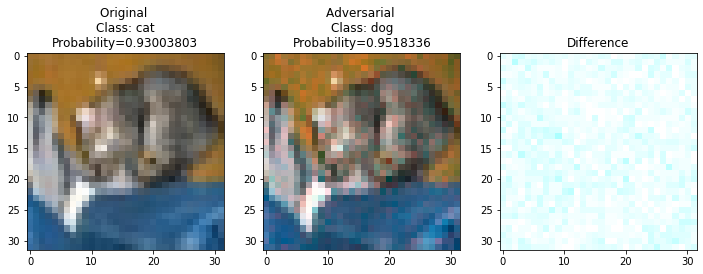

Iteration: 3653, epsilon: 0.050, probability: 0.949, init_label: 8, adv_label: 0

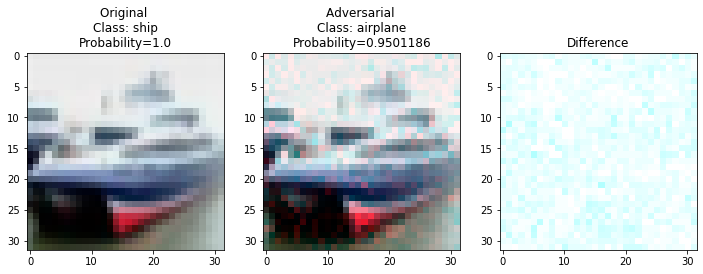

Iteration: 2196, epsilon: 0.050, probability: 0.946, init_label: 8, adv_label: 1

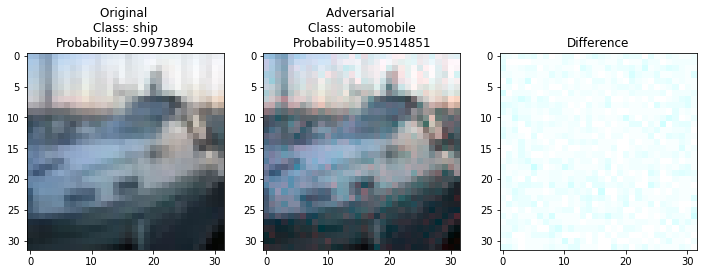

Iteration: 4439, epsilon: 0.075, probability: 0.944, init_label: 0, adv_label: 1

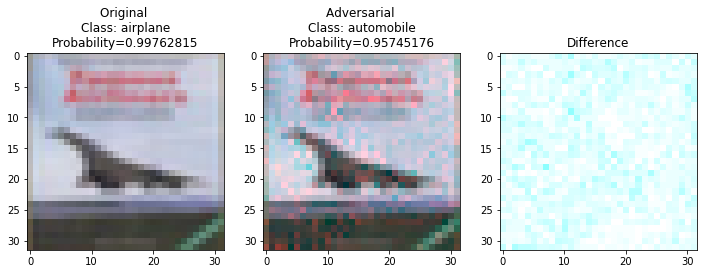

Iteration: 2992, epsilon: 0.050, probability: 0.906, init_label: 6, adv_label: 1

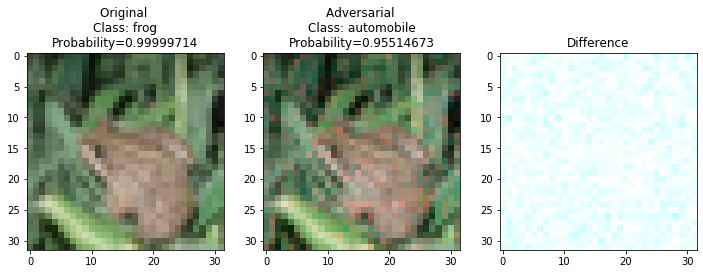

In [14]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1,3,32,32).to(device)).data.cpu().numpy()[0])

    x, difference = simba_single(net, example_data[i].reshape(1, 3,32,32).to(device), torch.tensor(example_targets[i]).to(device), num_iters=1000, epsilon=0.025)

    prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])
    
    fig, axes = plt.subplots(figsize=[12, 12])

    init_image = example.data.cpu().numpy().transpose((1,2,0))
    adv_image = x.data.cpu().numpy()[0].transpose((1,2,0))
    difference = difference.data.cpu().numpy()[0].transpose((1,2,0))
    
    plt.subplot(131)    
    plt.imshow(init_image)
    plt.title('Original ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_original)]) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    plt.subplot(132)
    plt.imshow(adv_image)
    plt.title('Adversarial ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_adv)]) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))
    
    plt.subplot(133)    
    plt.imshow(1-difference, cmap='gray')
    plt.title('Difference')

    plt.show()

## Fast gradient sign method

In [15]:
loss = torch.nn.CrossEntropyLoss()
example_data, example_targets = example_data.to(device), example_targets.to(device)
example_data.requires_grad = True
output = net(example_data)

loss_val = loss(output, example_targets)

net.zero_grad()
loss_val.backward()

data_grad = example_data.grad.data

In [16]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()

    init_label = np.argmax(net(image.cuda().reshape(1,3,32,32)).data.cpu().numpy())
    
    iteration = 0
    eps_init = epsilon
 
    while True:
        perturbed_image = image + epsilon*sign_data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
        adv_label = np.argmax(net(perturbed_image.cuda().reshape(1,3,32,32)).data.cpu().numpy())
        
        prob = np.max(softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0]))
        
        sys.stdout.write("\rIteration: %d, epsilon: %0.3f, init_label: %d, adv_label: %d" 
                         % (iteration, epsilon, init_label, adv_label))
        
        if init_label != adv_label:
            break
            
        iteration += 1
        
        if iteration > 2e4:
            break
        
        epsilon += eps_init
        
    return perturbed_image, torch.clamp(epsilon*sign_data_grad, 0, 1)

Iteration: 111, epsilon: 0.001, init_label: 3, adv_label: 5

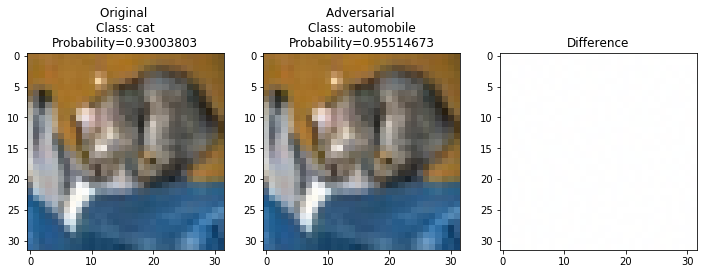

Iteration: 6250, epsilon: 0.063, init_label: 8, adv_label: 0

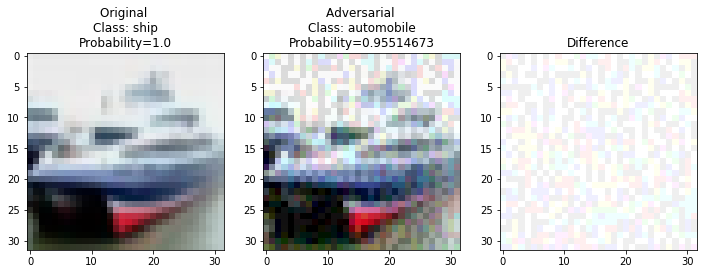

Iteration: 221, epsilon: 0.002, init_label: 8, adv_label: 1

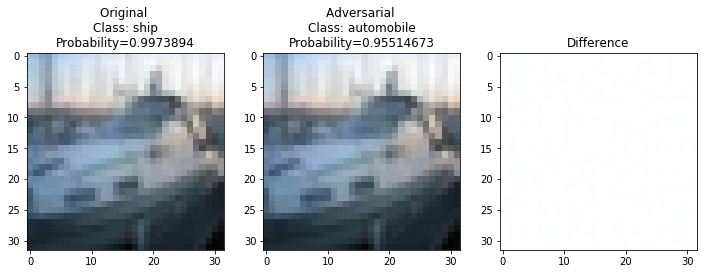

Iteration: 323, epsilon: 0.003, init_label: 0, adv_label: 8

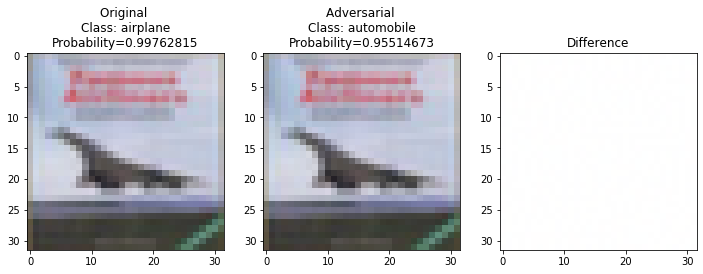

Iteration: 638, epsilon: 0.006, init_label: 6, adv_label: 2

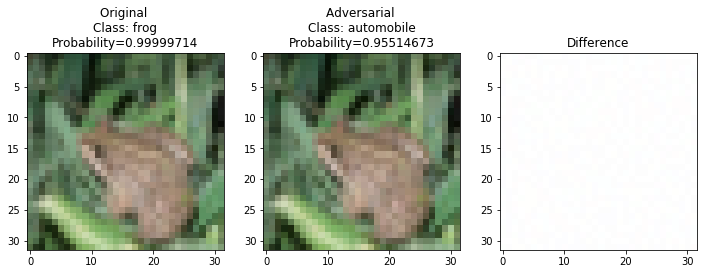

In [17]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    adv_image, difference = fgsm_attack(example_data[i], 1e-5, data_grad[i])
    prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])
    
    fig, axes = plt.subplots(figsize=[12, 12])

    init_image = example.data.cpu().numpy().transpose((1,2,0))
    adv_image = adv_image.data.cpu().numpy().transpose((1,2,0))
    difference = difference.data.cpu().numpy().transpose((1,2,0))
    
    plt.subplot(131)    
    plt.imshow(init_image)
    plt.title('Original ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_original)]) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    plt.subplot(132)
    plt.imshow(adv_image)
    plt.title('Adversarial ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_adv)]) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))
    
    plt.subplot(133)
    
    plt.imshow(1 - difference)
    plt.title('Difference')

    plt.show()

## Iterative Fast gradient sign method.

In [18]:
torch.retain_graph = True

In [19]:
def ifgsm_attack(example, example_target, net, loss, epsilon, iteration=1):
    
    example = example.reshape(1,3,32,32)
    example = torch.tensor(example, requires_grad=True)
    
    init_label = np.argmax(net(example.cuda().reshape(1,3,32,32)).data.cpu().numpy())
    
    while True:
        output = net(example.to('cuda:0'))
        loss_val = loss(output, example_target.to('cuda:0').reshape(-1))

        net.zero_grad()
        loss_val.backward()
        data_grad = example.grad.data
        sign_data_grad = data_grad.sign()
        perturbed_image = example + epsilon*sign_data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)     
        example = torch.tensor(perturbed_image, requires_grad=True)
        
        adv_label = np.argmax(net(perturbed_image.cuda().reshape(1,3,32,32)).data.cpu().numpy())
        
        iteration += 1
        
        sys.stdout.write("\rIteration: %d, init_label: %d, adv_label: %d" 
                         % (iteration, init_label, adv_label))
        
        if iteration > 1e5:
            break
            
        if init_label != adv_label:
            break
        
    return perturbed_image

/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 2, init_label: 3, adv_label: 5

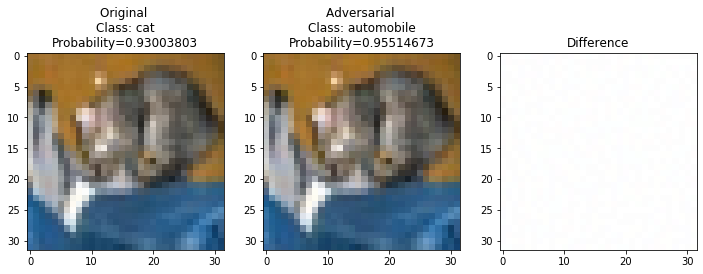

Iteration: 4, init_label: 8, adv_label: 0

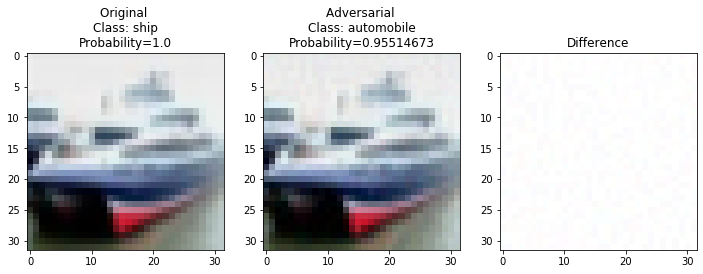

Iteration: 2, init_label: 8, adv_label: 1

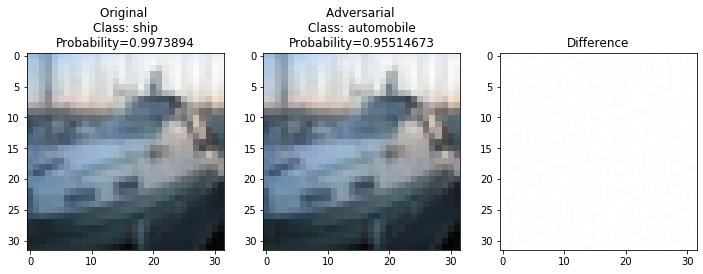

Iteration: 2, init_label: 0, adv_label: 8

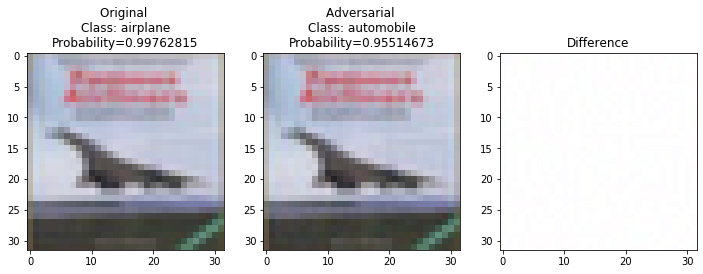

Iteration: 3, init_label: 6, adv_label: 2

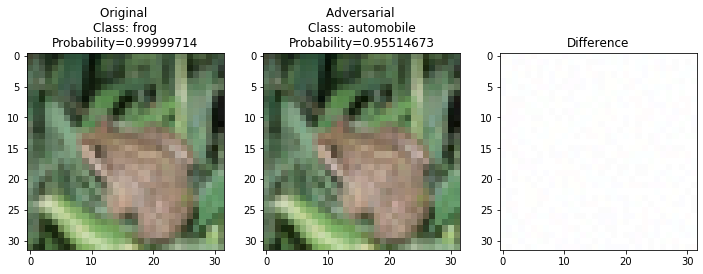

In [20]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    adv_image = ifgsm_attack(example, example_targets[i], net, loss, 0.005, iteration=1)
    prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])
    
    fig, axes = plt.subplots(figsize=[12, 12])

    init_image = example.data.cpu().numpy()
    adv_image = adv_image.data.cpu().numpy()[0]
    
    difference = adv_image - init_image
    
    difference = np.clip(difference.transpose((1,2,0)), 0, 1)
    init_image = init_image.transpose((1,2,0))
    adv_image = adv_image.transpose((1,2,0))
    
    plt.subplot(131)    
    plt.imshow(init_image)
    plt.title('Original ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_original)]) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    plt.subplot(132)
    plt.imshow(adv_image)
    plt.title('Adversarial ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_adv)]) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))
    
    plt.subplot(133)
    
    plt.imshow(1 - difference)
    plt.title('Difference')

    plt.show()

### Our method

In [21]:
from numpy.linalg import norm

In [22]:
train = torchvision.datasets.CIFAR10('Модель/Datasets', download=False, train=True, transform=test_tf)
trainloader = torch.utils.data.DataLoader(dataset=train, batch_size=10000, shuffle=False)

In [23]:
examples_train = enumerate(trainloader)
batch_idx, (train_data, train_targets) = next(examples)

In [24]:
train_data = train_data.to(device)
train_targets = train_targets.to(device)

In [34]:
def nearest_image(image, label, train_data, train_targets):
    image = image.data.cpu().numpy()[0]
    all_norm = []
    for i, train_image in enumerate(train_data):
        if train_targets[i].data.cpu().numpy() != label:
            train_image = train_image.data.cpu().numpy()
            diff = train_image - image
            norm_diff = norm(diff)
            all_norm.append(norm_diff)
        else:
            all_norm.append(1e20)            

    index = np.argmin(all_norm)
    return index



def our_attack(image, train_data, train_targets, eps):
    eps_init = eps
    init_label = np.argmax(net(example.cuda().reshape(1,3,32,32)).data.cpu().numpy())
    
    index = nearest_image(image, init_label, train_data, train_targets)
    
    while True:
        res = image + eps * (train_data[index] - image)
        adv_label = np.argmax(net(res.cuda().reshape(1,3,32,32)).data.cpu().numpy())
        
        if init_label != adv_label:
            break
            
        eps += eps_init
        
    return res.clamp(0, 255), train_data[index]

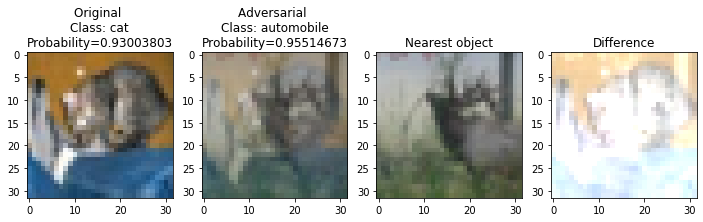

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


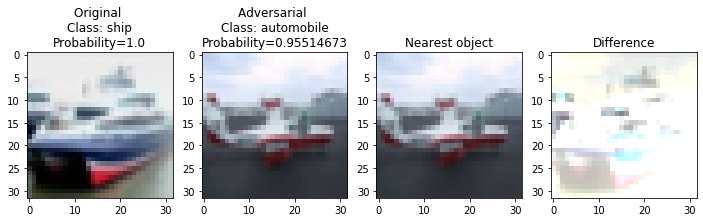

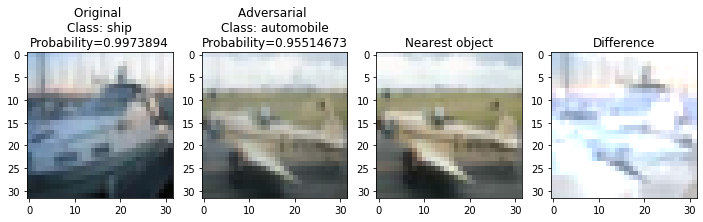

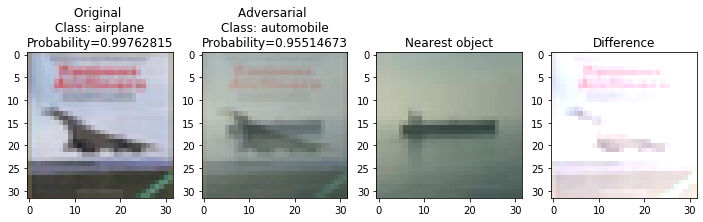

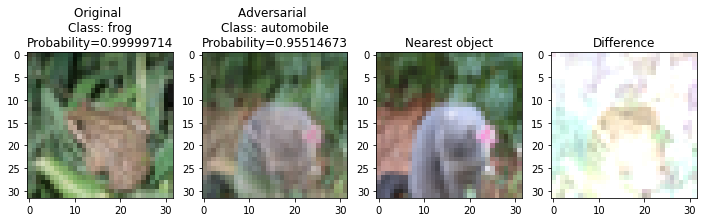

In [42]:
for i in range(5):
    example = example_data[i]
    prob_original = softmax(net(example.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])

    adv_image, nearest_object = our_attack(example, train_data, train_targets, 0.001)
    prob_adv = softmax(net(x.reshape(1, 3, 32, 32).to(device)).data.cpu().numpy()[0])
    
    fig, axes = plt.subplots(figsize=[12, 12])

    init_image = example.data.cpu().numpy()
    adv_image = adv_image.data.cpu().numpy()
    
    difference = adv_image - init_image
    
    difference = np.clip(difference.transpose((1,2,0)), 0, 1)
    init_image = init_image.transpose((1,2,0))
    adv_image = adv_image.transpose((1,2,0))
    nearest_object = nearest_object.cpu().numpy().transpose((1,2,0))
    
    plt.subplot(141)    
    plt.imshow(init_image)
    plt.title('Original ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_original)]) + '\n'
                      + 'Probability=' + str(np.max(prob_original)))
    plt.subplot(142)
    plt.imshow(adv_image)
    plt.title('Adversarial ' + '\n'
                      + 'Class: '+ str(labels[np.argmax(prob_adv)]) + '\n'
                      + 'Probability=' + str(np.max(prob_adv)))
    
    plt.subplot(143)
    plt.imshow(nearest_object)
    plt.title('Nearest object')
    
    plt.subplot(144)
    
    plt.imshow(1 - difference)
    plt.title('Difference')

    plt.show()